# Введение в искусственные нейронные сети
# Урок 1. Основы обучения нейронных сетей

## Домашнее задание

1. Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность (число нейронов, число эпох , можно изменять число слоев).
2. Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?

## построение  двухслойной нейронной сети на numpy

In [1]:
'''
Исходный код к уроку 1.
Построение двухслойной нейронный сети для классификации цветков ириса
'''

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hyperopt
# оптимизация по времени обучения сети и максимуму Accuracy
import timeit
from hyperopt import fmin, hp, tpe


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

In [2]:
### Шаг 1. Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = Y[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return (x)*(1 - (x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

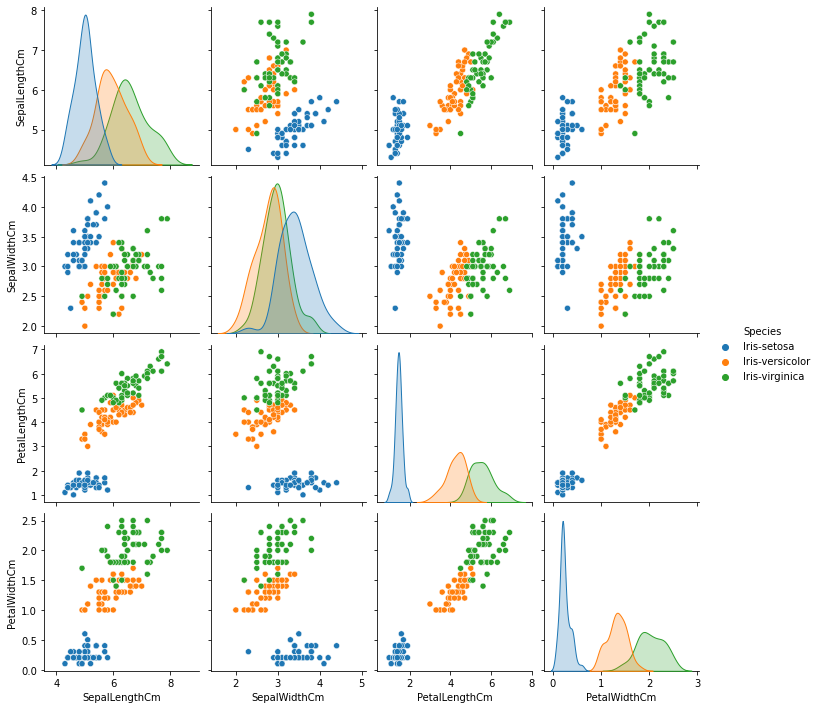

In [3]:

### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("Iris.csv")
# print(iris_data.head()) # расскоментируйте, чтобы посмотреть структуру данных

# репрезентация данных в виде графиков
g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
# plt.show() # расскоментируйте, чтобы посмотреть

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
#x = normalize(x.as_matrix())
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
#y = y.as_matrix()
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [4]:
### Шаг 3. Подготовка оптимизационной функции нейронной сети
# можно обернуть весовые коэффициенты и слои в более удобные структуры, но для наглядности все через if

def neural_net(params):
    # neuron_numb=5, learning_rate = 0.05
    model_params = {'neuron_numb': int(params['neuron_numb']),
                    'layers_numb': int(params['layers_numb']),
                    'learning_rate': params['learning_rate'],
                    'epochs': int(params['epochs'])
                   }
    # присваевание случайных весов
    if model_params['layers_numb'] == 2:
        # для входного слоя   - 4 входа, neuron_numb выходов
        w0 = 2*np.random.random((4, model_params['neuron_numb'])) - 1
        w1 = 2*np.random.random((model_params['neuron_numb'], 3)) - 1
        w2 = []
        w3 = []
    elif model_params['layers_numb'] == 3:
        w0 = 2*np.random.random((4, model_params['neuron_numb'])) - 1
        w1 = 2*np.random.random((model_params['neuron_numb'], model_params['neuron_numb'])) - 1
        # для выходного слоя - neuron_numb входов, 3 выхода
        w2 = 2*np.random.random((model_params['neuron_numb'], 3)) - 1
        w3 = []
    elif model_params['layers_numb'] == 4:
        w0 = 2*np.random.random((4, model_params['neuron_numb'])) - 1
        # для внутреннего слоя - neuron_numb входов, neuron_numb выхода
        w1 = 2*np.random.random((model_params['neuron_numb'], model_params['neuron_numb'])) - 1
        w2 = 2*np.random.random((model_params['neuron_numb'], model_params['neuron_numb'])) - 1
        w3 = 2*np.random.random((model_params['neuron_numb'], 3)) - 1
    
    # скорость обучения (learning rate)
    n = model_params['learning_rate']

    # массив для ошибок, чтобы потом построить график
    errors = []
    # процесс обучения
    for i in range(model_params['epochs']):

        # прямое распространение(feed forward)
        layer0 = X_train
        
        if model_params['layers_numb'] == 2:
            layer1 = sigmoid(np.dot(layer0, w0))
            layer2 = sigmoid(np.dot(layer1, w1))
        elif model_params['layers_numb'] == 3:
            layer1 = sigmoid(np.dot(layer0, w0))
            layer2 = sigmoid(np.dot(layer1, w1))
            layer3 = sigmoid(np.dot(layer2, w2))
        elif model_params['layers_numb'] == 4:
            layer1 = sigmoid(np.dot(layer0, w0))
            layer2 = sigmoid(np.dot(layer1, w1))
            layer3 = sigmoid(np.dot(layer2, w2))
            layer4 = sigmoid(np.dot(layer3, w3))

        # обратное распространение(back propagation) с использованием градиентного спуска
        if model_params['layers_numb'] == 2:
            layer2_error = y_train - layer2 # производная функции потерь = производная квадратичных потерь 
            layer2_delta = layer2_error * sigmoid_deriv(layer2)
            layer1_error = layer2_delta.dot(w1.T)
            layer1_delta = layer1_error * sigmoid_deriv(layer1)
        elif model_params['layers_numb'] == 3:
            layer3_error = y_train - layer3 # производная функции потерь = производная квадратичных потерь 
            layer3_delta = layer3_error * sigmoid_deriv(layer3)
            layer2_error = layer3_delta.dot(w2.T)
            layer2_delta = layer2_error * sigmoid_deriv(layer2)
            layer1_error = layer2_delta.dot(w1.T)
            layer1_delta = layer1_error * sigmoid_deriv(layer1)
        elif model_params['layers_numb'] == 4:
            layer4_error = y_train - layer4 # производная функции потерь = производная квадратичных потерь 
            layer4_delta = layer4_error * sigmoid_deriv(layer4)
            layer3_error = layer4_delta.dot(w3.T)
            layer3_delta = layer3_error * sigmoid_deriv(layer3)
            layer2_error = layer3_delta.dot(w2.T)
            layer2_delta = layer2_error * sigmoid_deriv(layer2)
            layer1_error = layer2_delta.dot(w1.T)
            layer1_delta = layer1_error * sigmoid_deriv(layer1)

        # коррекция
        if model_params['layers_numb'] == 2:
            w1 += layer1.T.dot(layer2_delta) * n
            w0 += layer0.T.dot(layer1_delta) * n
        elif model_params['layers_numb'] == 3:
            w2 += layer2.T.dot(layer3_delta) * n
            w1 += layer1.T.dot(layer2_delta) * n
            w0 += layer0.T.dot(layer1_delta) * n
        elif model_params['layers_numb'] == 4:
            w3 += layer3.T.dot(layer4_delta) * n
            w2 += layer2.T.dot(layer3_delta) * n
            w1 += layer1.T.dot(layer2_delta) * n
            w0 += layer0.T.dot(layer1_delta) * n

        # метрика модели
        if model_params['layers_numb'] == 2:
            output_layer = layer2
            error = np.mean(np.abs(layer2_error))
        elif model_params['layers_numb'] == 3:
            output_layer = layer3
            error = np.mean(np.abs(layer3_error))
        elif model_params['layers_numb'] == 4:
            output_layer = layer4
            error = np.mean(np.abs(layer4_error))
        errors.append(error)
        accuracy = (1 - error) * 100
        w = {0:w0,1:w1,2:w2,3:w3}
    return accuracy, errors, model_params, output_layer, w
    
def plot_neural_data(errors, accuracy, y_train, output_layer):
    
    # Демонстрация полученных результатов
    # черчение диаграммы точности в зависимости от обучения
    plt.figure(figsize = (16,5))
    plt.plot(errors)
    plt.xlabel('Обучение')
    plt.ylabel('Ошибка')
    plt.grid()
    plt.show() # расскоментируйте, чтобы посмотреть 

    N = 50
    plt.figure(figsize = (16,5))
    plt.plot(output_layer[:N,1], 'r',label = 'Predicted Y')
    plt.plot(y_train[:N,1],'g', label = 'Real Y')
    plt.xlabel('№ примера')
    plt.ylabel('выход сети и целевой')
    plt.legend( )
    plt.grid()
    plt.show() # расскоментируйте, чтобы посмотреть 

    print("Аккуратность нейронной сети " + str(round(accuracy,2)) + "%")


In [5]:
def neural_score(params):
    accuracy, errors, _, _, _= neural_net(params)
    score = 1/accuracy
    return

In [6]:
# поиск лучших параметров - вылетает!
"""param={'neuron_numb': hp.choice('neuron_numb', [5]),
       'layers_numb': hp.choice('layers_numb', [2]),
       'learning_rate': hp.uniform('learning_rate', 0.001, 0.1),
       'epochs': hp.uniform('epochs', 100, 10000)
      }
n_iter = 10

best=fmin(neural_score, # function to optimize
          space=param, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
         )"""
"""best_params = {'neuron_numb': int(best['neuron_numb']),
               'layers_numb': int(best['layers_numb']),
               'learning_rate': best['depth'],
               'epochs': int(best['epochs'])
              }"""

"best_params = {'neuron_numb': int(best['neuron_numb']),\n               'layers_numb': int(best['layers_numb']),\n               'learning_rate': best['depth'],\n               'epochs': int(best['epochs'])\n              }"

In [7]:
%%time

for i in range(500,4000,800):
    best_params = {'neuron_numb': 5,
                   'layers_numb': 2,
                   'learning_rate': 0.05,
                   'epochs': i
                  }
    accuracy, errors, model_params, output_layer, w = neural_net(best_params)
    print(best_params)
    print("Аккуратность нейронной сети " + str(round(accuracy,2)) + "%")
    print('____________________________________________________')


{'neuron_numb': 5, 'layers_numb': 2, 'learning_rate': 0.05, 'epochs': 500}
Аккуратность нейронной сети 79.39%
____________________________________________________
{'neuron_numb': 5, 'layers_numb': 2, 'learning_rate': 0.05, 'epochs': 1300}
Аккуратность нейронной сети 92.39%
____________________________________________________
{'neuron_numb': 5, 'layers_numb': 2, 'learning_rate': 0.05, 'epochs': 2100}
Аккуратность нейронной сети 94.03%
____________________________________________________
{'neuron_numb': 5, 'layers_numb': 2, 'learning_rate': 0.05, 'epochs': 2900}
Аккуратность нейронной сети 95.28%
____________________________________________________
{'neuron_numb': 5, 'layers_numb': 2, 'learning_rate': 0.05, 'epochs': 3700}
Аккуратность нейронной сети 95.66%
____________________________________________________
CPU times: user 905 ms, sys: 18.2 ms, total: 923 ms
Wall time: 1.04 s


In [8]:
%%time
for i in range(2,5):
    best_params = {'neuron_numb': 5,
                   'layers_numb': i,
                   'learning_rate': 0.05,
                   'epochs': 3700
                  }
    accuracy, errors, model_params, output_layer, w = neural_net(best_params)
    print(best_params)
    print("Аккуратность нейронной сети " + str(round(accuracy,2)) + "%")
    print('____________________________________________________')

{'neuron_numb': 5, 'layers_numb': 2, 'learning_rate': 0.05, 'epochs': 3700}
Аккуратность нейронной сети 95.78%
____________________________________________________
{'neuron_numb': 5, 'layers_numb': 3, 'learning_rate': 0.05, 'epochs': 3700}
Аккуратность нейронной сети 96.76%
____________________________________________________
{'neuron_numb': 5, 'layers_numb': 4, 'learning_rate': 0.05, 'epochs': 3700}
Аккуратность нейронной сети 96.9%
____________________________________________________
CPU times: user 1.33 s, sys: 22.2 ms, total: 1.35 s
Wall time: 1.86 s


In [9]:
learning_rates = np.dot(list(range(1, 100, 15)),0.001)

In [10]:
%%time
for i in learning_rates:
    best_params = {'neuron_numb': 5,
                   'layers_numb': 2,
                   'learning_rate': i,
                   'epochs': 3700
                  }
    accuracy, errors, model_params, output_layer, w = neural_net(best_params)
    print(best_params)
    print("Аккуратность нейронной сети " + str(round(accuracy,2)) + "%")
    print('____________________________________________________')

{'neuron_numb': 5, 'layers_numb': 2, 'learning_rate': 0.001, 'epochs': 3700}
Аккуратность нейронной сети 67.16%
____________________________________________________
{'neuron_numb': 5, 'layers_numb': 2, 'learning_rate': 0.016, 'epochs': 3700}
Аккуратность нейронной сети 91.57%
____________________________________________________
{'neuron_numb': 5, 'layers_numb': 2, 'learning_rate': 0.031, 'epochs': 3700}
Аккуратность нейронной сети 94.62%
____________________________________________________
{'neuron_numb': 5, 'layers_numb': 2, 'learning_rate': 0.046, 'epochs': 3700}
Аккуратность нейронной сети 95.32%
____________________________________________________
{'neuron_numb': 5, 'layers_numb': 2, 'learning_rate': 0.061, 'epochs': 3700}
Аккуратность нейронной сети 95.98%
____________________________________________________
{'neuron_numb': 5, 'layers_numb': 2, 'learning_rate': 0.076, 'epochs': 3700}
Аккуратность нейронной сети 96.39%
____________________________________________________
{'neuron_n

In [11]:
%%time
for i in [2,3,4,5,6]:
    best_params = {'neuron_numb': i,
                   'layers_numb': 2,
                   'learning_rate': 0.091,
                   'epochs': 3700
                  }
    accuracy, errors, model_params, output_layer, w = neural_net(best_params)
    print(best_params)
    print("Аккуратность нейронной сети " + str(round(accuracy,2)) + "%")
    print('____________________________________________________')

{'neuron_numb': 2, 'layers_numb': 2, 'learning_rate': 0.091, 'epochs': 3700}
Аккуратность нейронной сети 84.1%
____________________________________________________
{'neuron_numb': 3, 'layers_numb': 2, 'learning_rate': 0.091, 'epochs': 3700}
Аккуратность нейронной сети 96.32%
____________________________________________________
{'neuron_numb': 4, 'layers_numb': 2, 'learning_rate': 0.091, 'epochs': 3700}
Аккуратность нейронной сети 96.51%
____________________________________________________
{'neuron_numb': 5, 'layers_numb': 2, 'learning_rate': 0.091, 'epochs': 3700}
Аккуратность нейронной сети 96.74%
____________________________________________________
{'neuron_numb': 6, 'layers_numb': 2, 'learning_rate': 0.091, 'epochs': 3700}
Аккуратность нейронной сети 96.67%
____________________________________________________
CPU times: user 1.34 s, sys: 14.7 ms, total: 1.35 s
Wall time: 1.45 s


## Очевидно что увеличение количества эпох, слоев, нейронов увеличивает accuracy. Количество эпох и скорость обучения имеют ключевое значение для скорости обучения из-за повторения операций обучения на каждой эпохе.

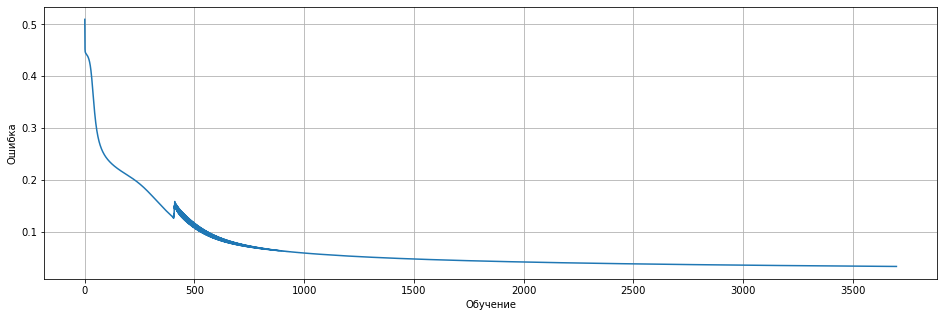

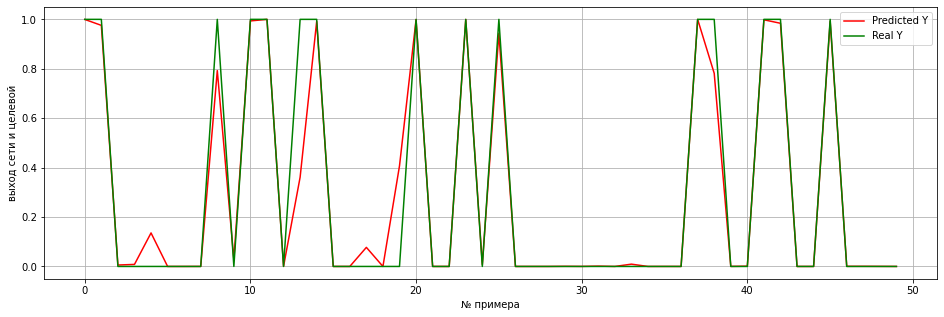

Аккуратность нейронной сети 96.71%


In [12]:
best_params = {'neuron_numb': i,
                   'layers_numb': 2,
                   'learning_rate': 0.091,
                   'epochs': 3700
                  }
accuracy, errors, model_params, output_layer, w = neural_net(best_params)

plot_neural_data(errors, accuracy, y_train, output_layer)

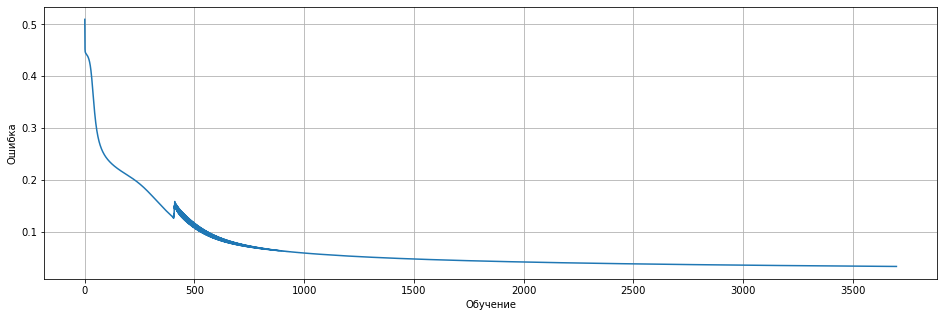

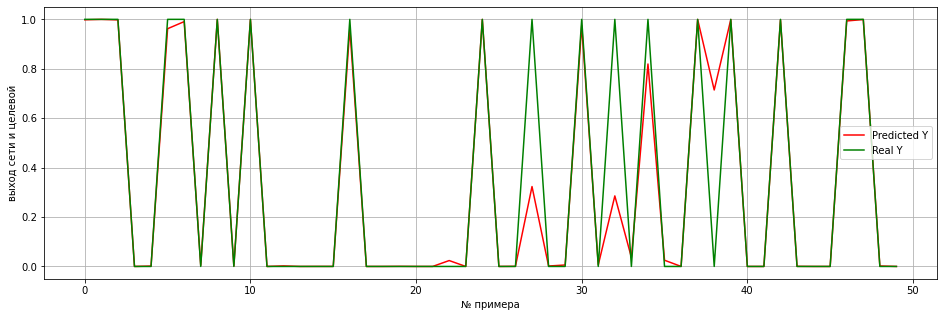

Аккуратность нейронной сети 96.71%
Аккуратность нейронной сети на тесте 96.23%


In [13]:
# прямое распространение(feed forward)
layer0_t = X_test
if best_params['layers_numb'] == 2:
    layer1_t = sigmoid(np.dot(layer0_t, w[0]))
    output_layer = sigmoid(np.dot(layer1_t, w[1]))
    output_layer_error_t = y_test - output_layer
elif best_params['layers_numb'] == 3:
    layer1_t = sigmoid(np.dot(layer0_t, w[0]))
    layer2_t = sigmoid(np.dot(layer1_t, w[1]))
    output_layer = sigmoid(np.dot(layer2_t, w[2]))
    output_layer_error_t = y_test - output_layer
elif best_params['layers_numb'] == 4:
    layer1_t = sigmoid(np.dot(layer0_t, w[0]))
    layer2_t = sigmoid(np.dot(layer1_t, w[1]))
    layer3_t = sigmoid(np.dot(layer2_t, w[2]))
    output_layer = sigmoid(np.dot(layer3_t, w[3]))
    output_layer_error_t = y_test - output_layer
    
plot_neural_data(errors, accuracy, y_test, output_layer)


# метрика модели
error_t = np.mean(np.abs(output_layer_error_t))
accuracy_t = (1 - error_t) * 100
print("Аккуратность нейронной сети на тесте " + str(round(accuracy_t,2)) + "%")

## Дополнительные материалы

<ol>
    <li>https://medium.com/topic/machine-learning</li>
</ol>

## Используемая литература 

Для подготовки данного методического пособия были использованы следующие ресурсы:
<ol>
    <li>Глубокое обучение — Николенко С. И., Кадурин 2018</li>
    <li>Шакла Н. — Машинное обучение и TensorFlow 2019</li>
    <li>Asifullah Khan, Anabia Sohail, Umme Zahoora, Aqsa Saeed Qureshi - A Survey of the Recent Architectures of Deep Convolutional Neural Networks 2019</li>
    <li>A direct adaptive method for faster backpropagation learning: the RPROP algorithm - Neural Networks, 1993</li>
    <li>Википедия</li>
    
</ol>